# Advanced Data Analysis Project
### Prof. Scheideger 
### Coronavirus Pandemic
#### Antoine-Michel Alexeev & Benjamin Souane


In [1]:
# Import packages
import pandas as pd
import world_bank_data as wb
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import calendar
import seaborn as sns
from decimal import Decimal
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy import distance
import plotly as py
import plotly.graph_objects as go
import ipywidgets
from ipywidgets import widgets
import sklearn.model_selection
from sklearn import preprocessing
from sklearn import metrics
from scipy import optimize
import csv
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/dhlib/py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/dhlib/py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/dhlib/py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/dhlib/py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/dhlib/py3/lib/p

## Import Data

### Get Data from John Hopkins 

In [2]:
# Loading Covid 19 Data
public_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
corona_data = pd.read_csv(public_url)
corona_data.drop(['Lat','Long','Province/State'],axis=1)
countries = sorted(corona_data['Country/Region'].unique())
country_data = corona_data.groupby('Country/Region').sum()
country_data = country_data.drop(['Lat','Long'],axis=1)
country_data = country_data.rename(columns={'Country/Region':'Country'},index={'US':'United States'})

### Get Data from the World Bank

In [3]:
# Get GDP data
GDP = pd.DataFrame(wb.get_series('NY.GDP.MKTP.CD',mrv=1))
GDP = GDP.droplevel(level=[1,2]) # Droping multi level indexing

# Get gini Index
Gini = pd.DataFrame(wb.get_series('SI.POV.GINI',date = '2010'))
Gini = Gini.droplevel(level=[1,2]) # Droping multi level indexing

# Get population data
Pop = pd.DataFrame(wb.get_series('SP.POP.TOTL',mrv=1))
Pop = Pop.droplevel(level=[1,2]) # Droping multi level indexing

# Get Health System Data
Health = pd.DataFrame(wb.get_series('SH.MED.BEDS.ZS',date = '2010'))
Health = Health.droplevel(level=[1,2]) # Droping multi level indexing

# Get Density Data
Dens = pd.DataFrame(wb.get_series('EN.POP.DNST',mrv=1))
Dens = Dens.droplevel(level=[1,2])

# Get Trade data
Trade = pd.DataFrame(wb.get_series('NE.TRD.GNFS.ZS',mrv=1))
Trade = Trade.droplevel(level=[1,2])

# Get Child mortality data
Child = pd.DataFrame(wb.get_series('SP.DYN.IMRT.IN',mrv=1))
Child = Child.droplevel(level=[1,2])
Child = Child/1000

#Get total number of cases 
Total = pd.DataFrame(country_data.sum(axis=1), columns=['Total'])

### Politics Data

In [5]:
politics = pd.read_csv('politics.csv')
politics = politics.set_index('Country Name')
politics = politics.drop(['Series Name','Country Code','Series Code'], axis=1)
politics = politics.rename(columns = {'2018 [YR2018]':'Political Stability'})

### Government Effectiveness

In [6]:
GOV = pd.read_csv('governement.csv')
GOV = GOV.set_index('Country Name')
GOV = GOV.drop(['Series Name','Country Code','Series Code'], axis=1)
GOV = GOV.rename(columns = {'2018 [YR2018]':'GOV'})

### Downloaded Data

In [7]:
# Economist businnes unit
df = pd.read_excel('_EIU-Democracy Indices - Dataset - v3.xlsx')
year = df['time'] == 2018
DEM = df[year]
DEM = DEM.drop(['geo','a','b','c','d','e','time','f'],axis = 1)
DEM = DEM.set_index('name')
DEM = DEM.rename(columns={'name':'Country'})

# Continent data
Cont = pd.read_csv('Countries-Continents.csv')
Cont = Cont.set_index('Country')
Cont = Cont.rename(index={'US':'United States'})

### Merge Data

In [8]:
allData = country_data.join([Total,GDP,Gini,DEM,Pop,Health,Child,Dens,Trade,Cont,politics,GOV])
allData.rename(columns={'NY.GDP.MKTP.CD':'GDP',
                          'SI.POV.GINI':'Gini',
                          'Democracy index (EIU)':'Dem',
                       'SP.POP.TOTL':'Pop',
                       'SH.MED.BEDS.ZS': 'Health',
                        'SP.DYN.IMRT.IN':'Child',
                       'EN.POP.DNST':'Dens',
                       'NE.TRD.GNFS.ZS':'Trade',
                        'Political Stability	':'Political Stability'
                      },inplace=True)
allData = allData.dropna()

### Getting distances between countries

In [9]:
geolocator = Nominatim(user_agent="my-application")

In [10]:
Distance = []
count=0
countries = list(allData.index)
Wuhan = geolocator.geocode("Wuhan")
Wuhan = (Wuhan.latitude, Wuhan.longitude)

In [11]:
for i in countries[0:16]:
    c = geolocator.geocode(i)
    Distance.append(distance.distance((c.latitude, c.longitude), Wuhan).km)
    count += 1
for i in countries[16:33]:
    c = geolocator.geocode(i)
    Distance.append(distance.distance((c.latitude, c.longitude), Wuhan).km)
    count += 1
for i in countries[33:45]:
    c = geolocator.geocode(i)
    Distance.append(distance.distance((c.latitude, c.longitude), Wuhan).km)
    count += 1
for i in countries[45:59]:
    c = geolocator.geocode(i)
    Distance.append(distance.distance((c.latitude, c.longitude), Wuhan).km)
    count += 1

In [12]:
Distances = pd.DataFrame(Distance, index =list(allData.index),columns =['Distance'])

In [13]:
allData = allData.join([Distances])

### Class imbalances

In [14]:
def count(myclass,data):
    q = np.linspace(0,1,11)
    quantile = np.array(data[myclass].quantile(q))
    count = np.zeros((10,1)).reshape(-1,1)
    for j in range(10):
        subset_count =  (quantile[j] <= data[myclass]) & (data[myclass] < quantile[j+1])
        count[j] = data[myclass][subset_count].count()

    for i, c in enumerate(count):
        print('# quantile',myclass,'%.2E' % Decimal(quantile[1:11][i]),'=',c) 

In [15]:
num_cols=['GDP','Gini','Dem','Pop','Health','Child','Dens','Trade','Political Stability','GOV','Distance']
#GDP
count(num_cols[0],allData)

# quantile GDP 2.27E+10 = [6.]
# quantile GDP 3.29E+10 = [6.]
# quantile GDP 5.62E+10 = [6.]
# quantile GDP 7.38E+10 = [6.]
# quantile GDP 2.18E+11 = [5.]
# quantile GDP 3.07E+11 = [6.]
# quantile GDP 4.85E+11 = [6.]
# quantile GDP 7.32E+11 = [6.]
# quantile GDP 1.79E+12 = [6.]
# quantile GDP 2.05E+13 = [5.]


In [16]:
#Gini
count(num_cols[1],allData)

# quantile Gini 2.77E+01 = [5.]
# quantile Gini 2.96E+01 = [7.]
# quantile Gini 3.17E+01 = [6.]
# quantile Gini 3.31E+01 = [6.]
# quantile Gini 3.41E+01 = [5.]
# quantile Gini 3.54E+01 = [6.]
# quantile Gini 3.91E+01 = [6.]
# quantile Gini 4.29E+01 = [6.]
# quantile Gini 4.72E+01 = [6.]
# quantile Gini 5.56E+01 = [5.]


In [17]:
#Dem
count(num_cols[2],allData)

# quantile Dem 4.33E+01 = [6.]
# quantile Dem 5.62E+01 = [6.]
# quantile Dem 6.25E+01 = [6.]
# quantile Dem 6.55E+01 = [6.]
# quantile Dem 7.03E+01 = [5.]
# quantile Dem 7.69E+01 = [6.]
# quantile Dem 7.97E+01 = [6.]
# quantile Dem 8.44E+01 = [6.]
# quantile Dem 9.14E+01 = [6.]
# quantile Dem 9.87E+01 = [5.]


In [18]:
#Pop
count(num_cols[3],allData)

# quantile Pop 2.04E+06 = [6.]
# quantile Pop 3.62E+06 = [6.]
# quantile Pop 5.63E+06 = [6.]
# quantile Pop 8.85E+06 = [6.]
# quantile Pop 1.02E+07 = [5.]
# quantile Pop 1.60E+07 = [6.]
# quantile Pop 2.97E+07 = [6.]
# quantile Pop 5.22E+07 = [6.]
# quantile Pop 8.54E+07 = [6.]
# quantile Pop 1.39E+09 = [5.]


In [19]:
#Health
count(num_cols[4],allData)

# quantile Health 1.20E+00 = [5.]
# quantile Health 1.76E+00 = [7.]
# quantile Health 2.58E+00 = [6.]
# quantile Health 3.04E+00 = [6.]
# quantile Health 3.56E+00 = [5.]
# quantile Health 4.46E+00 = [6.]
# quantile Health 5.32E+00 = [6.]
# quantile Health 6.24E+00 = [6.]
# quantile Health 7.20E+00 = [5.]
# quantile Health 1.15E+01 = [6.]


In [20]:
#Dens
count(num_cols[5],allData)

# quantile Child 2.10E-03 = [5.]
# quantile Child 2.90E-03 = [6.]
# quantile Child 3.18E-03 = [7.]
# quantile Child 3.60E-03 = [3.]
# quantile Child 5.60E-03 = [8.]
# quantile Child 7.48E-03 = [6.]
# quantile Child 8.98E-03 = [6.]
# quantile Child 1.28E-02 = [6.]
# quantile Child 1.66E-02 = [6.]
# quantile Child 5.72E-02 = [5.]


In [21]:
#Trade
count(num_cols[6],allData)

# quantile Dens 1.59E+01 = [6.]
# quantile Dens 2.50E+01 = [6.]
# quantile Dens 4.58E+01 = [6.]
# quantile Dens 7.10E+01 = [6.]
# quantile Dens 8.57E+01 = [5.]
# quantile Dens 1.07E+02 = [6.]
# quantile Dens 1.24E+02 = [6.]
# quantile Dens 1.71E+02 = [6.]
# quantile Dens 2.75E+02 = [6.]
# quantile Dens 1.51E+03 = [5.]


In [22]:
#RDI
count(num_cols[7],allData)

# quantile Trade 4.32E+01 = [6.]
# quantile Trade 6.03E+01 = [6.]
# quantile Trade 6.65E+01 = [6.]
# quantile Trade 7.60E+01 = [6.]
# quantile Trade 8.70E+01 = [5.]
# quantile Trade 9.75E+01 = [6.]
# quantile Trade 1.10E+02 = [6.]
# quantile Trade 1.26E+02 = [6.]
# quantile Trade 1.63E+02 = [6.]
# quantile Trade 3.87E+02 = [5.]


### Plots

a. Confirmed Cases

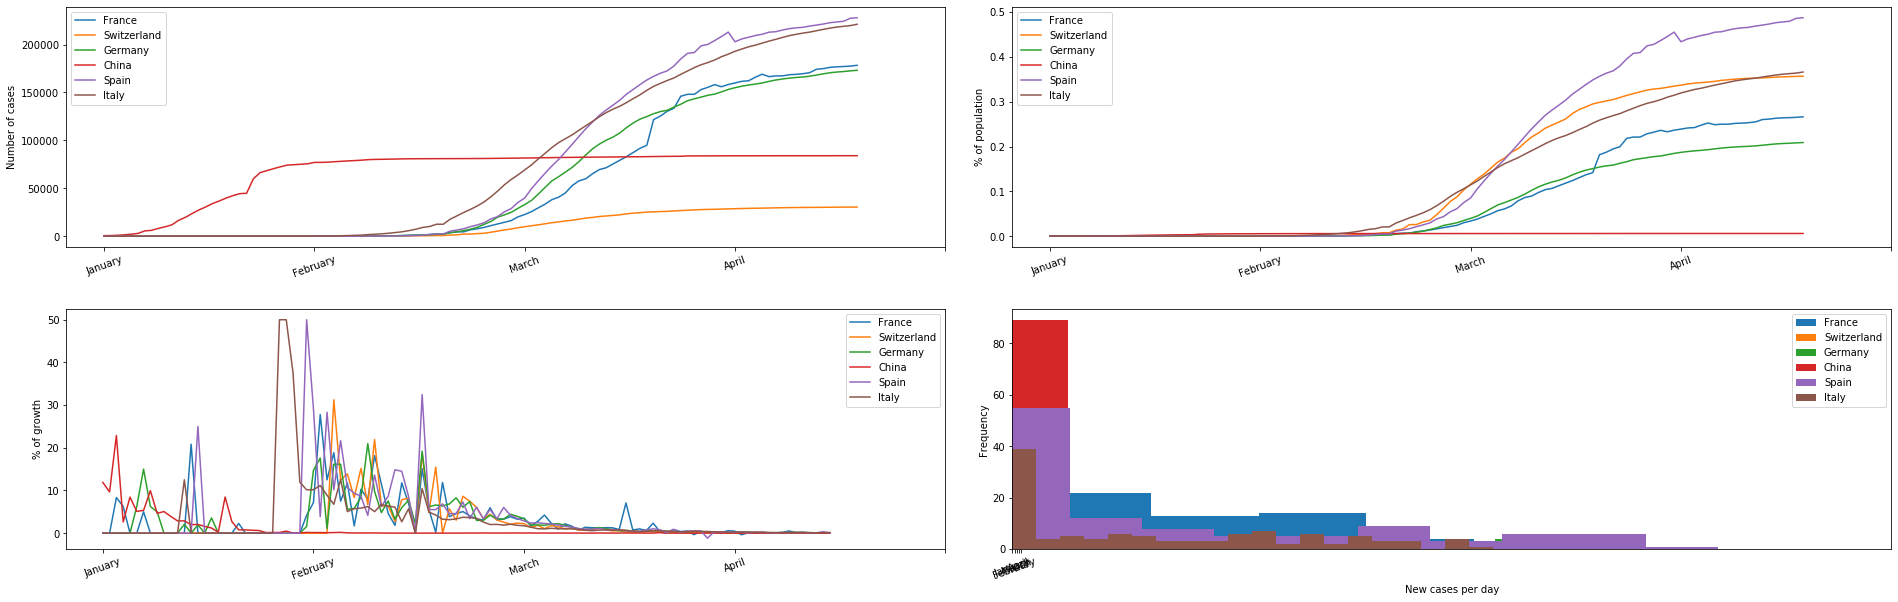

In [23]:
countries = ['France','Switzerland','Germany','China','Spain','Italy']

fig = plt.figure(figsize=(27,9))
plt.subplot(221)
for country in countries:
    toplot = country_data.loc[country,:]
    plt.plot(toplot)
plt.legend(countries)
plt.xticks(np.linspace(0,len(allData.columns)-1,5), calendar.month_name[1:5], rotation=20)
plt.ylabel('Number of cases')
plt.subplot(222)
for country in countries:
    toplot = country_data.loc[country,:]/allData.loc[country,'Pop']*100
    plt.plot(toplot)
plt.legend(countries)
plt.xticks(np.linspace(0,len(allData.columns)-1,5), calendar.month_name[1:5], rotation=20)
plt.ylabel('% of population')
plt.subplot(223)
for country in countries:
    toplot = []
    for time in range(len(country_data.columns)-4):
        if country_data.loc[country,country_data.columns[time]] != 0:
            for flat in range(0,4): 
                meanGrowth = 0
                Growth = (country_data.loc[country,country_data.columns[time+1+flat]]/
                      country_data.loc[country,country_data.columns[time+flat]] - 1)*100
                meanGrowth = meanGrowth + Growth
                if meanGrowth > 200:
                    meanGrowth = 200
            toplot.append(meanGrowth/4)
        else:
            toplot.append(0)
    plt.plot(toplot)
plt.legend(countries)
plt.xticks(np.linspace(0,len(allData.columns)-1,5), calendar.month_name[1:5], rotation=20)
plt.ylabel('% of growth')
plt.subplot(224)
for country in countries:
    toplot = []
    for time in range(len(country_data.columns)-1):
        toplot.append(country_data.loc[country,country_data.columns[time+1]]-
        country_data.loc[country,country_data.columns[time]])
    plt.hist(toplot,bins=20)
plt.legend(countries)
plt.xlim([0,12000])
plt.xticks(np.linspace(0,len(allData.columns)-1,5), calendar.month_name[1:5], rotation=20)
plt.ylabel('Frequency')
plt.xlabel('New cases per day')
fig.tight_layout(pad=3.0)
plt.show()


### Interactive Graphs

In [24]:
countries = np.array(allData.index)
 
def update_plot(c):     
    data=[] 
    for country in c:
        layout = go.Layout(
            title = country,
            yaxis = dict(
                title = 'Cases'
                ),
            xaxis = dict(
                title = 'Date'
                )
            )
        trace1 = go.Scatter(
            x = allData.columns,
            y = country_data.loc[country,:],
            mode = 'lines',
            name = country,
            line = dict(
                shape = 'spline'
            )
        )
        data.append(trace1)

    fig = go.Figure(data=data, layout=layout)
    fig.show()

c = widgets.SelectMultiple(options=countries, value = ['Armenia'], description='Country')
widgets.interactive(update_plot, c=c)

interactive(children=(SelectMultiple(description='Country', index=(1,), options=('Argentina', 'Armenia', 'Aust…

In [25]:
country_day = country_data.diff(axis=1)

In [26]:
def update_plots(signal):     
    data=[]  
    for country in signal:
        layout = go.Layout(
            title = country,
            yaxis = dict(
                title = 'Cases per day'
                ),
            xaxis = dict(
                title = 'Date'
                )
            )
    
        trace1 = go.Scatter(
            x = allData.columns,
            y = country_day.loc[country,:],
            mode = 'lines',
            name = country,
            line = dict(
                shape = 'spline'
            )
        )
        data.append(trace1)

    fig = go.Figure(data=data, layout=layout)
    fig.show()

signal = widgets.SelectMultiple(options=countries, value = ['Argentina'], description='Country')
widgets.interactive(update_plots, signal=signal)

interactive(children=(SelectMultiple(description='Country', index=(0,), options=('Argentina', 'Armenia', 'Aust…

b. all countries

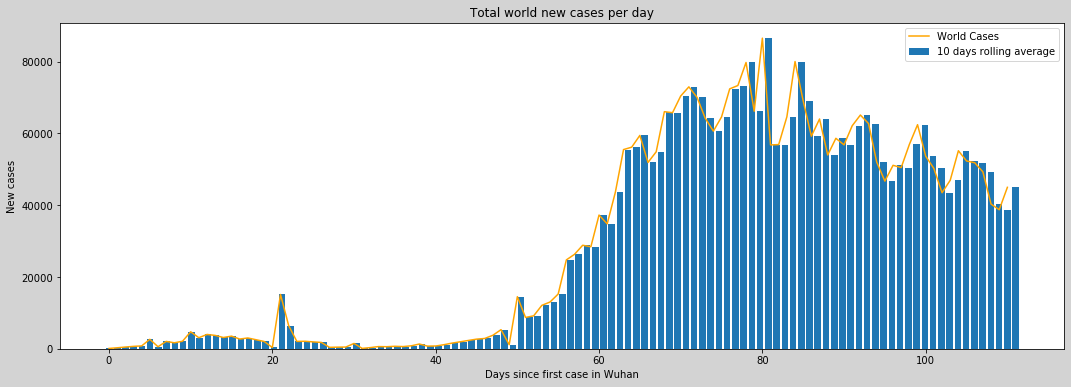

In [27]:
#Bar plot of the new cases
fig = plt.figure(figsize=[18,6])
graph = []
graph2 = []
for time in range(len(country_data.columns)-1):
    value = 0
    for country in allData.index:
        toplot = (country_data.loc[country,country_data.columns[time+1]]-country_data.loc[country,country_data.columns[time]])
        value = value  + toplot
    graph.append(value)
date = pd.date_range(start="2020-02-22",end="2020-04-16")
plt.bar(np.linspace(0,len(graph),len(graph)),np.asarray(graph))
plt.title('Total world new cases per day')
fig.set_facecolor('lightgrey')
plt.ylabel('New cases')
plt.xlabel('Days since first case in Wuhan')
plt.legend('World Cases')
for time in range(len(country_data.columns)-10):
    for country in allData.index:
        for flat in range(0,10):
            toplot = (country_data.loc[country,country_data.columns[time+1+flat]]-country_data.loc[country,country_data.columns[time+flat]])
            value = value  + toplot
        graph2.append(value/10)
plt.plot(graph,color='orange')
plt.legend(['World Cases','10 days rolling average'])
plt.show()

c. Geographical repartion

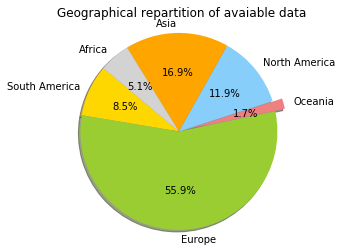

In [28]:
Continents = allData.loc[:,'Continent'].unique()
count = []
for continent in Continents:
    condObj = allData.apply(lambda x: True if x['Continent'] == continent else False, axis =1)
    count.append(len(condObj[condObj == True].index))
    

# Data to plot
labels = Continents
sizes = count
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','orange','lightgrey']
explode = (0, 0, 0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Geographical repartition of avaiable data')
plt.axis('equal')
plt.show()

In [29]:
allData['GOV']=allData.GOV.astype(float)
allData['Child']=allData.Child.astype(float)
allData['Political Stability']=allData['Political Stability'].astype(float)

### Splitting the predictors and target

In [30]:
y = allData.drop(['Total','GDP', 'Gini', 'Dem', 'Pop', 'Health','Child',
                  'Dens', 'Trade','Continent','Political Stability','GOV','Distance'],axis = 1)

X = allData.loc[:,['Total','GDP', 'Gini', 'Dem', 'Pop', 'Health','Child',
                  'Dens', 'Trade','Continent','Political Stability','GOV','Distance']]


#### One hot encoder for religion and continent

In [31]:
FeaturesContinent = X['Continent']
X = X.drop(['Continent'], axis = 1)
enc = preprocessing.LabelEncoder()

encC = enc.fit(FeaturesContinent)
FeaturesContinent = encC.transform(FeaturesContinent)

In [32]:
ohe = preprocessing.OneHotEncoder()
encodedC = ohe.fit(FeaturesContinent.reshape(-1,1))

FeaturesContinent = encodedC.transform(FeaturesContinent.reshape(-1,1)).toarray()

/dhlib/py3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



In [33]:
Features = np.concatenate([FeaturesContinent], axis = 1)

In [34]:
Features = np.concatenate([Features, np.array(X[['GDP', 'Gini', 'Dem', 'Pop', 'Health','Child',
                                                 'Dens','Trade','Political Stability','GOV','Distance']])], axis = 1)
Data = pd.DataFrame(Features, index = countries, columns= ['South America',
                                                           'Europe', 'Oceania', 'North America','Asia',
                                                           'Africa', 'GDP', 'Gini', 'Dem', 'Pop',
                                                           'Health','Child','Dens','Trade','Political Stability','GOV','Distance'] )

### Finding first cases

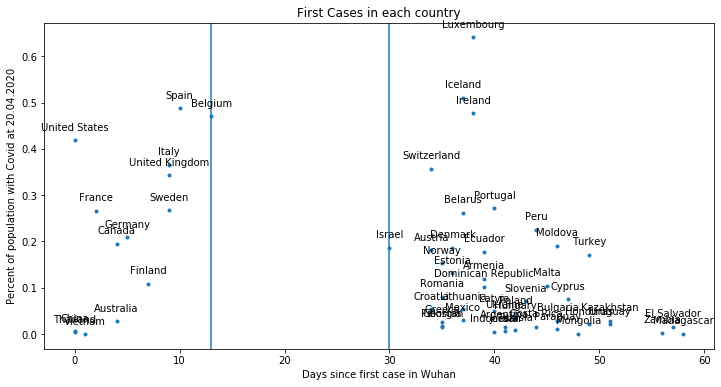

In [35]:
# Finding first case
nonZero = []
InonZero = []
for country in y.index:
    for i, date in enumerate(y.columns):
        if y.loc[country,date] != 0:
            index = y.columns.get_loc(date)
            nonZero.append(index)
            InonZero.append(i)
            break
frac = y.iloc[:,-1]/X.loc[:,'Pop']*100
fig = plt.figure(figsize=[12,6])
plt.plot(nonZero,frac,'.')
plt.title('First Cases in each country')
plt.xlabel('Days since first case in Wuhan')
plt.ylabel('Percent of population with Covid at 20.04.2020')

count = 0
for x,z in zip(nonZero,frac):
    
    label = y.index[count]

    plt.annotate(label, # this is the text
                 (x,z), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    count += 1
plt.axvline(x = 13)
plt.axvline(x = 30)
plt.show()

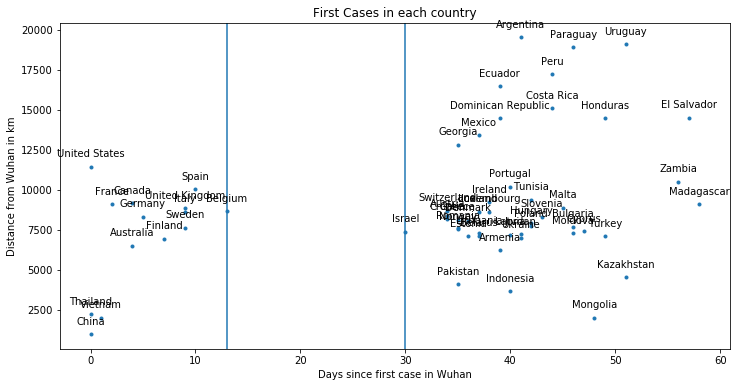

In [36]:
# Finding first case
nonZero = []
for country in y.index:
    for date in y.columns:
        if y.loc[country,date] != 0:
            index = y.columns.get_loc(date)
            nonZero.append(index)
            break
fig = plt.figure(figsize=[12,6])
plt.plot(nonZero,allData['Distance'],'.')
plt.title('First Cases in each country')
plt.xlabel('Days since first case in Wuhan')
plt.ylabel('Distance from Wuhan in km')

count = 0
for x,z in zip(nonZero,allData['Distance']):
    
    label = y.index[count]

    plt.annotate(label, # this is the text
                 (x,z), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    count += 1
plt.axvline(x = 13)
plt.axvline(x = 30)
plt.show()

### Heatmap correlation

In [37]:
y1=y.diff(axis=1)

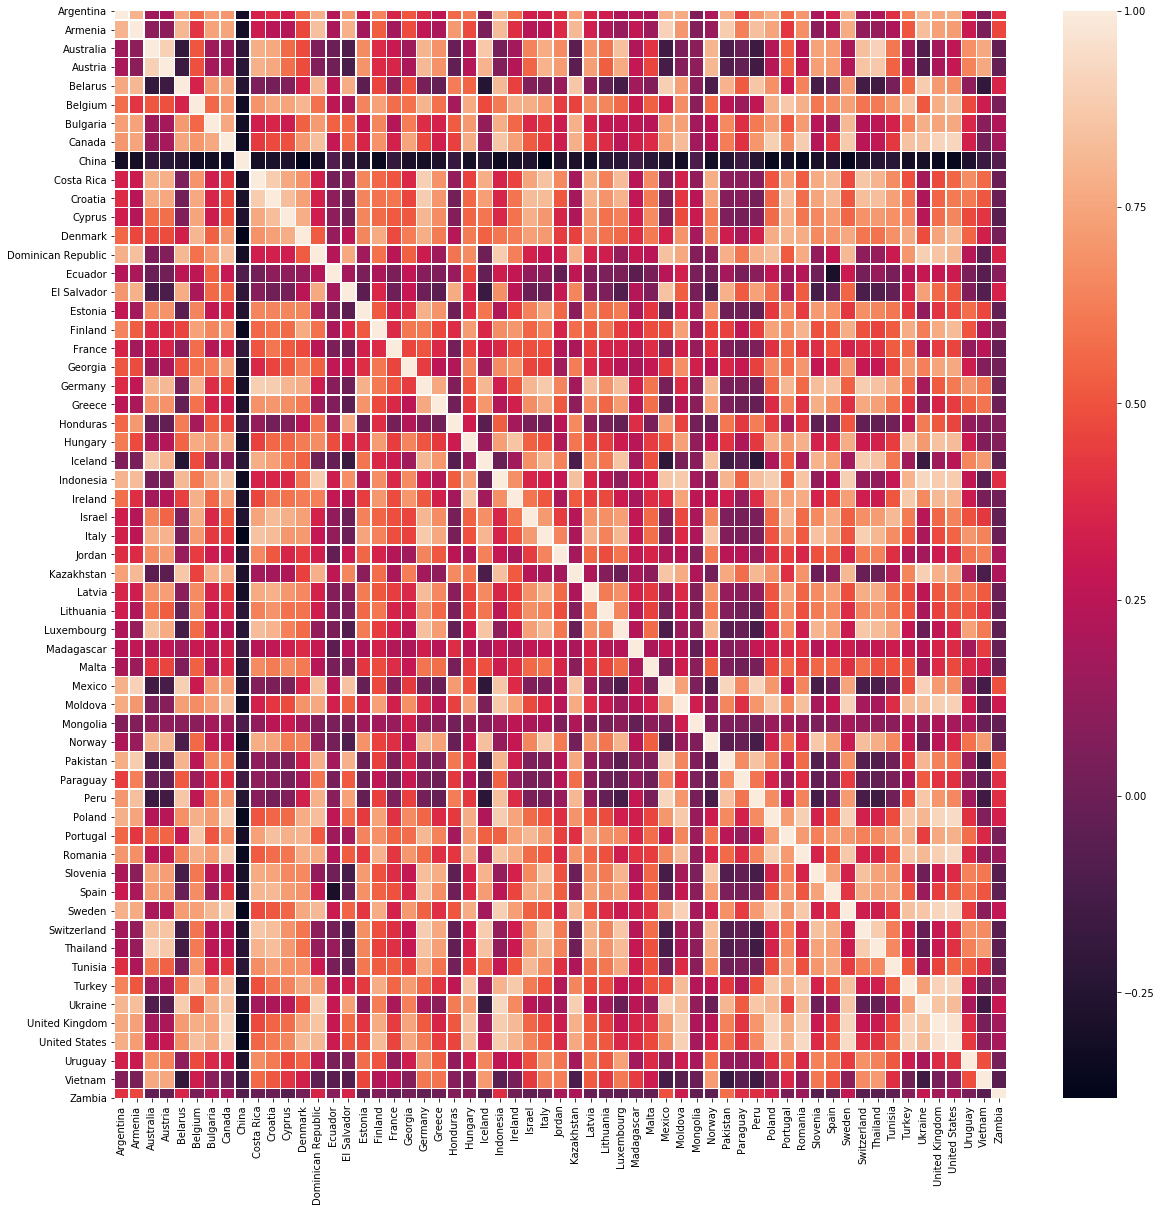

In [38]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(y1.transpose().corr(), linewidths=.5, ax=ax)
plt.savefig('corr.png')

In [39]:
corrCountry = y1.transpose().corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

In [40]:
corrCountry

### Adding first case Data

In [41]:
InonZero = pd.DataFrame(np.array(InonZero),index = countries, columns= {'First Case'})

In [42]:
Data = Data.join(InonZero)

### Gradient descent

We want to find the minimum square error between our approximation and real shape of data. For this we pick some numbers and compute the square errors so we have some starting points for the newton gradient descent. We use a newton gradient descent to find the optimal parameters. The function and the gradients:
$$f(x) = \frac{L}{1+e^{-k(x_i - x_0)}$$


In [43]:
# Setting to compute first derivative
def J(j,ytrue,x):
    gl = 0
    gk = 0
    gx0 = 0
    for i in range(len(ytrue)):
        gl = gl + (j[0]/(1+np.exp(j[1]*(j[2]-x[i])))-ytrue[i])/(1+np.exp(j[1]*(j[2]-x[i])))

        gk = gk + (ytrue[i]-j[0]/(1+np.exp(j[1]*(j[2]-x[i]))))*(j[0]/((1+np.exp(j[1]*(j[2]-x[i])))**2))*(j[2]-x[i])*np.exp(j[1]*(j[2]-x[i]))
    
        gx0 = gx0 + (ytrue[i]-j[0]/(1+np.exp(j[1]*(j[2]-x[i]))))*(j[0]/(1+np.exp(j[1]*(j[2]-x[i])))**2)*j[1]*np.exp(j[1]*(j[2]-x[i]))
        
    gl = 2*gl
    gk = 2*gk
    gx0 = 2*gx0
    p=np.array([gl,gk,gx0], dtype=np.float128)
    return p

In [44]:
# Setting gradient descent function
def Newton(w,country,ytrue,x): 
    count = 0
    Maxcount = 10000
    Delta = 1 # Start with a random delta that will decrease,hopefully.
    alpha = 0.001 #alpha
    while count<Maxcount and Delta>10**(-14):
        p = J(w,ytrue,x)
        wOld = w
        w = w - alpha*p
        Delta = np.sum((w-wOld)**2)
        count += 1
    ypred = np.zeros((len(ytrue),1),dtype=np.float128)
    for i in range(len(ytrue)):
        ypred[i] = w[0]/(1+np.exp(w[1]*(w[2]-x[i])))
    return w, ypred

In [45]:
def best(country):
    #Finding first case
    for i, date in enumerate(y.columns):
        if y.loc[country,date] != 0:
            ytrue = y.loc[country,y.columns[i-1]:y.columns[-2]]
            break
    
    #Set true cumulated cases in % of population
    ytrue = np.array(ytrue/X.loc[country,'Pop']*100)
    x = np.linspace(0,len(ytrue)-1,len(ytrue)) 
    
    #Create L,K and X0 points to test
    L = np.linspace(0,1,101)
    K = np.linspace(0,0.3,31)
    X0 = np.linspace(0,100,101)
    
    #Finding best points that gives the min square error between true curve and function curve
    lb = 0
    kb = 0
    x0b = 0
    lsOld = 10000
    for i, l in enumerate(L):
        for j, k in enumerate(K):
            for t, z in enumerate(X0):                
                ls = 0
                for q in range(len(ytrue)):
                    ls = ls + (ytrue[q]-l/(1+np.exp(k*(z-q))))**2  
                if (ls < lsOld):
                    lb = L[i]
                    kb = K[j]
                    x0b = X0[t]
                    lsOld = ls
                else:
                    pass
    
    #With the optimal point we do a Newton gradient descent
    j = np.array([lb,kb,x0b])
    w, ypred = Newton(j, country, ytrue, x)
    return w, ypred, ytrue, x

### Import data

As the optimisation take long time, we stored the results in a csv format, so we can use it fastly afterwards. 

In [46]:
#Reopen data
import csv
with open('Time.csv') as csv_file:
    reader = csv.reader(csv_file)
    T = dict(reader)

with open('Predictions.csv') as csv_file:
    reader = csv.reader(csv_file)
    Ypred = dict(reader)

with open('True.csv') as csv_file:
    reader = csv.reader(csv_file)
    Ytrue = dict(reader)
    
with open('W.csv') as csv_file:
    reader = csv.reader(csv_file)
    W = dict(reader)

### Comparing plots

In [47]:
def compare_plots(c):     
    data=[] 
    for country in c:
        timing = []
        yt = []
        yp = []
        t = T["Time " + country].replace('[', '').replace(']', '').split()
        t = pd.DataFrame(t).values
        Pred = Ypred["Prediction " + country].replace('[', '').replace(']', '').split()
        Pred = pd.DataFrame(Pred).values
        true = Ytrue["True " + country].replace('[', '').replace(']', '').split()
        true = pd.DataFrame(true).values
        for j in t:
            timing.append(float(j))
        for i in Pred:
            yt.append(float(i))
        for i in true:
            yp.append(float(i))  

        layout = go.Layout(
            title = country,
            yaxis = dict(
                title = 'Cases'
                ),
            xaxis = dict(
                title = 'Date'
                )
            )
        trace1 = go.Scatter(
            x = timing,
            y = yt,
            mode = 'lines',
            name = 'Pred' + country,
            line = dict(
                shape = 'spline'
            )
        )
        trace2 = go.Scatter(
            x = timing,
            y = yp,
            mode = 'lines',
            name = 'True' + country,
            line = dict(
                shape = 'spline'
            )
        )
        data.append(trace1)
        data.append(trace2)

    fig = go.Figure(data=data, layout=layout)
    fig.show()

cont = widgets.SelectMultiple(options=countries, value = ['Armenia'], description='Country')
widgets.interactive(compare_plots, c=cont)

interactive(children=(SelectMultiple(description='Country', index=(1,), options=('Argentina', 'Armenia', 'Aust…

# Prediction Model

### Regressions 

In [48]:
#We have to arrange the values from the csv to input it in pandas DataFrame
Lmax = []
Ks = []
X0s =[]
for country in countries:
    p = W["Parameters " + country].replace('[', '').replace(']', '').split()
    p = pd.DataFrame(p).values
    ws = []
    for j in p:
        ws.append(float(j))
    Lmax.append(ws[0])
    Ks.append(ws[1])
    X0s.append(ws[2])      

In [49]:
#We format the true value of paremeters in pandas DataFrame
Lmax = pd.DataFrame(Lmax, columns = ['L'], index = countries)
Ks = pd.DataFrame(Ks, columns = ['K'], index = countries)
X0s = pd.DataFrame(X0s, columns = ['x0'], index = countries)
OptiParam = Lmax.join([Ks,X0s])

In [50]:
#Setting list of data columns
col_data = Data.columns

In [55]:
# Splitting the data
Split = np.random.permutation(Data.index)
NumSplit = 40
TrainSplit = Split[0:NumSplit]
TestSplit = Split[NumSplit:len(Data.index)]

# Import Gaussian Process 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Predicting the value with different linear_model
LR = LinearRegression()
GPR = GaussianProcessRegressor()
Ridge = Ridge()
Lasso = Lasso(alpha=10)

#Setting function for prediction
def Prediction(Predictor, Parameter):

    LR.fit(Data.loc[TrainSplit,Predictor],Parameter.loc[TrainSplit])
    y_predict = LR.predict(Data.loc[TestSplit,Predictor])
    print('R2 score = ',LR.score(Data.loc[TestSplit,Predictor],Parameter.loc[TestSplit]))
    print('MSE = ',metrics.mean_squared_error(Parameter.loc[TestSplit],y_predict))

    GPR.fit(Data.loc[TrainSplit,Predictor],Parameter.loc[TrainSplit])
    y_GPRpredict = GPR.predict(Data.loc[TestSplit,Predictor])
    print('R2 GPR score = ',GPR.score(Data.loc[TestSplit,Predictor],Parameter.loc[TestSplit]))
    print('MSE GPR = ',metrics.mean_squared_error(Parameter.loc[TestSplit],y_GPRpredict))

    Ridge.fit(Data.loc[TrainSplit,Predictor],Parameter.loc[TrainSplit])
    y_Ridgepredict = Ridge.predict(Data.loc[TestSplit,Predictor])
    print('R2 Ridge score = ',Ridge.score(Data.loc[TestSplit,Predictor],Parameter.loc[TestSplit]))
    print('MSE Ridge = ',metrics.mean_squared_error(Parameter.loc[TestSplit],y_Ridgepredict))

    Lasso.fit(Data.loc[TrainSplit,Predictor],Parameter.loc[TrainSplit])
    y_Lassopredict = Lasso.predict(Data.loc[TestSplit,Predictor])
    print('R2 Lasso score = ',Lasso.score(Data.loc[TestSplit,Predictor],Parameter.loc[TestSplit]))
    print('MSE Lasso = ',metrics.mean_squared_error(Parameter.loc[TestSplit],y_Lassopredict),'\n')
    
    return y_predict, y_GPRpredict, y_Ridgepredict, y_Lassopredict

PredictorL = ['GDP','Gini','Pop']
PredictorK = ['Gini','Dens','Health','Distance']
PredictorX0 = ['First Case']

y_predict_L, y_GPRpredict_L, y_Ridgepredict_L, y_Lassopredict_L = Prediction(PredictorL,Lmax)
y_predict_K, y_GPRpredict_K, y_Ridgepredict_K, y_Lassopredict_K = Prediction(PredictorK,Ks)
y_predict_X0, y_GPRpredict_X0, y_Ridgepredict_X0, y_Lassopredict_X0 = Prediction(PredictorX0,X0s)

R2 score =  0.04487372415820834
MSE =  0.029480440806968315
R2 GPR score =  -0.8895640833321846
MSE GPR =  0.058322321894612915


/dhlib/py3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning:

Ill-conditioned matrix (rcond=2.86627e-24): result may not be accurate.



R2 Ridge score =  0.04485644253612664
MSE Ridge =  0.029480974212707133
R2 Lasso score =  -0.0351066114001759
MSE Lasso =  0.0319490730787298 

R2 score =  -0.07062290252229042
MSE =  0.0019013159089254195
R2 GPR score =  -8.264898083064198
MSE GPR =  0.016453503916647093
R2 Ridge score =  -0.07039330567335855
MSE Ridge =  0.0019009081685898775
R2 Lasso score =  -0.27864454047093656
MSE Lasso =  0.002270740893857731 

R2 score =  0.011390265040882475
MSE =  502.3253910031438
R2 GPR score =  -2.5040841899197153
MSE GPR =  1780.4704916062205
R2 Ridge score =  0.011388356593195703
MSE Ridge =  502.3263607100934
R2 Lasso score =  0.0034740972421937193
MSE Lasso =  506.3476982332939 



### Prediction Curve 

In [56]:
# We take the predicitons of the parameters and construct the curve with them
def curve_pred(L,K,X0):
    ypred=np.zeros((len(L),151))
    for i in range(len(L)):
        for j in range(151):
            ypred[i,j]= L[i]/(1+np.exp(K[i]*(X0[i]-j)))
    return ypred

ypredLR = curve_pred(y_predict_L,y_predict_K,y_predict_X0)   
ypredGPR = curve_pred(y_GPRpredict_L,y_GPRpredict_K,y_GPRpredict_X0)  
ypredRidge = curve_pred(y_Ridgepredict_L,y_Ridgepredict_K,y_Ridgepredict_X0)  
ypredLasso = curve_pred(y_Lassopredict_L,y_Lassopredict_K,y_Lassopredict_X0)  

In [58]:
#We plot the true values, the prediction with function and prediciton with regressors
def compare_plots(c):     
    data=[] 
    for count, country in enumerate(c):
        timing = []
        yt = []
        yp = []
        
        t = T["Time " + country].replace('[', '').replace(']', '').split()
        t = pd.DataFrame(t).values
        Pred = Ypred["Prediction " + country].replace('[', '').replace(']', '').split()
        Pred = pd.DataFrame(Pred).values
        true = Ytrue["True " + country].replace('[', '').replace(']', '').split()
        true = pd.DataFrame(true).values
        
        for j in t:
            timing.append(float(j))
        for i in Pred:
            yt.append(float(i))
        for i in true:
            yp.append(float(i))  

        layout = go.Layout(
            title = country,
            yaxis = dict(
                title = 'Cases'
                ),
            xaxis = dict(
                title = 'Date'
                )
            )
        trace1 = go.Scatter(
            x = timing,
            y = yt,
            mode = 'lines',
            name = 'Pred' + country,
            line = dict(
                shape = 'spline'
            )
        )
        trace2 = go.Scatter(
            x = timing,
            y = yp,
            mode = 'lines',
            name = 'True' + country,
            line = dict(
                shape = 'spline'
            )
        )
        trace3 = go.Scatter(
            x = timing,
            y = ypredLR[count,0:len(yp)],
            mode = 'lines',
            name = 'Linear Regression' + country,
            line = dict(
                shape = 'spline'
            )
        )
        data.append(trace1)
        data.append(trace2)
        data.append(trace3)

    fig = go.Figure(data=data, layout=layout)
    fig.show()

cont = widgets.SelectMultiple(options=countries, value = ['Australia'], description='Country')
widgets.interactive(compare_plots, c=cont)

interactive(children=(SelectMultiple(description='Country', index=(2,), options=('Argentina', 'Armenia', 'Aust…

### Neural Network

In [59]:
# Model By Benjamin 

# 1. Processing the Data
# ***************************************************************************************
    
    
    
# 2.Creating the model
# ***************************************************************************************
# Function to build the model
def build_model():
    model = keras.Sequential([
        layers.Dense(8, activation='relu', input_shape=[18]),
        layers.Dense(4, activation='sigmoid'),
        layers.Dense(2)
      ])

    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    return model

# Building the model
model = build_model()



# 3. Fitting the data
# ***************************************************************************************

# Number of presentation of the data
EPOCHS = 10000

# Early stopping implementation
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Fitting the model
FitModel = model.fit(
  Data.loc[TrainSplit], OptiParam.loc[TrainSplit, ['K','L']],
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[early_stop])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


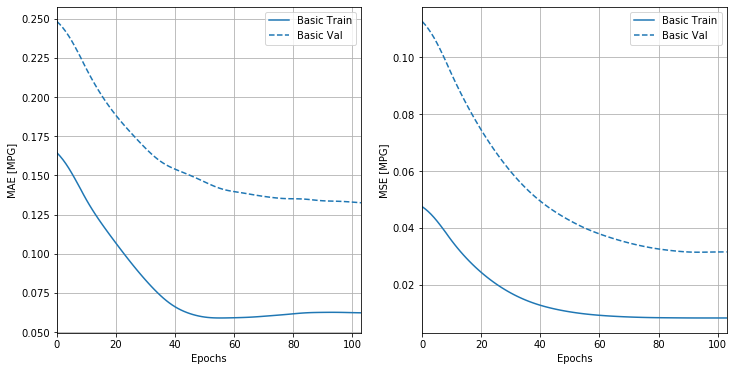

In [62]:
import tensorflow_docs.plots
# 4. Ploting the Loss 
# ***************************************************************************************
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plotter.plot({'Basic': FitModel}, metric = "mean_absolute_error")

plt.ylabel('MAE [MPG]')
plt.subplot(122)
plotter.plot({'Basic': FitModel}, metric = "mean_squared_error")

plt.ylabel('MSE [MPG]')
plt.show()

In [63]:
# 5. Evaluating the model
# **************************************************************************************

loss, mae, mse = model.evaluate(Data.loc[TestSplit], OptiParam.loc[TestSplit,  ['K','L']], verbose=2)

 - 0s - loss: 0.0190 - mean_absolute_error: 0.0860 - mean_squared_error: 0.0190


In [64]:
ParaPred_NN = model.predict(Data.loc[TestSplit])

In [65]:
ParaPred_NN

array([[0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912],
       [0.10535484, 0.09490912]], dtype=float32)

In [66]:
def customPredict_NN(Weights, y):
    
    YpredAll = np.zeros([y.shape[0],300])
    
    for count, country in enumerate(y.index):
        for time in range(300):
            YpredAll[count, time] = (Weights[count, 1]/(1+np.exp(Weights[count, 0]*(y.loc[country, 'x0']-time))))
            
        
    return YpredAll

Ypred_NN = customPredict_NN(ParaPred_NN, OptiParam.loc[TestSplit])

In [ ]:
#We plot the true values, the prediction with function and prediciton with regressors
def compare_plots(c):     
    data=[] 
    for count, country in enumerate(c):
        timing = []
        yt = []
        yp = []
        
        t = T["Time " + country].replace('[', '').replace(']', '').split()
        t = pd.DataFrame(t).values
        Pred = Ypred["Prediction " + country].replace('[', '').replace(']', '').split()
        Pred = pd.DataFrame(Pred).values
        true = Ytrue["True " + country].replace('[', '').replace(']', '').split()
        true = pd.DataFrame(true).values
        
        for j in t:
            timing.append(float(j))
        for i in Pred:
            yt.append(float(i))
        for i in true:
            yp.append(float(i))  

        layout = go.Layout(
            title = country,
            yaxis = dict(
                title = 'Cases'
                ),
            xaxis = dict(
                title = 'Date'
                )
            )
        trace1 = go.Scatter(
            x = timing,
            y = yt,
            mode = 'lines',
            name = 'Pred' + country,
            line = dict(
                shape = 'spline'
            )
        )
        trace2 = go.Scatter(
            x = timing,
            y = yp,
            mode = 'lines',
            name = 'True' + country,
            line = dict(
                shape = 'spline'
            )
        )
        trace3 = go.Scatter(
            x = timing,
            y =Ypred_NN[count,0:len(yp)],
            mode = 'lines',
            name = 'Model' + country,
            line = dict(
                shape = 'spline'
            )
        )
        data.append(trace1)
        data.append(trace2)
        data.append(trace3)

    fig = go.Figure(data=data, layout=layout)
    fig.show()

cont = widgets.SelectMultiple(options=list(TestSplit), value = ['Australia'], description='Country')
widgets.interactive(compare_plots, c=cont)

# Death cases

In [68]:
# Loading Covid 19 Data
public_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
corona_data = pd.read_csv(public_url)
corona_data.drop(['Lat','Long','Province/State'],axis=1)
countries = sorted(corona_data['Country/Region'].unique())
country_data = corona_data.groupby('Country/Region').sum()
country_data = country_data.drop(['Lat','Long'],axis=1)
country_data = country_data.rename(columns={'Country/Region':'Country'},index={'US':'United States'})

In [69]:
countries = sorted(death['Entity'].unique())

NameError: name 'death' is not defined

In [70]:
country_data

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,85,90,95,104,106,109,115,120,122,127
Albania,0,0,0,0,0,0,0,0,0,0,...,31,31,31,31,31,31,31,31,31,31
Algeria,0,0,0,0,0,0,0,0,0,0,...,463,465,470,476,483,488,494,502,507,515
Andorra,0,0,0,0,0,0,0,0,0,0,...,45,45,46,46,47,47,48,48,48,48
Angola,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
Western Sahara,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Yemen,0,0,0,0,0,0,0,0,0,0,...,2,2,4,5,5,7,7,8,9,10


In [ ]:
d = death[death['Entity']=='Afghanistan']
x = d[' (deaths)'].values.reshape(1,-1)
dates = d['Date'].values
country = ['Afghanistan']

In [ ]:
for i, c in enumerate(countries): 
    d = death[death['Entity']==c]
    d = d[' (deaths)'].values.reshape(1,-1)
    row , col = d.shape
    if (i == 0) or (col != 134) :
        pass
    else:
        x = np.concatenate((x, d), axis=0)
        country.append(c)

In [ ]:
death = pd.DataFrame(x, columns = dates, index = country)

In [ ]:
death = death.dropna(axis=1)

In [ ]:
con = list(death.index)

def update_plot(c):     
    data=[] 
    for country in c:
        layout = go.Layout(
            title = country,
            yaxis = dict(
                title = 'Cases'
                ),
            xaxis = dict(
                title = 'Date'
                )
            )
        trace1 = go.Scatter(
            x = death.columns,
            y = death.loc[country,:],
            mode = 'lines',
            name = country,
            line = dict(
                shape = 'spline'
            )
        )
        data.append(trace1)

    fig = go.Figure(data=data, layout=layout)
    fig.show()

c = widgets.SelectMultiple(options=con, value = ['Armenia'], description='Country')
widgets.interactive(update_plot, c=c)